<h1>Learning How to Read Handwritten Digits</h1>

In [1]:
import numpy as np, import_ipynb
import matplotlib.pyplot as plt
from feedforwardneuralnetwork import FeedForwardNeuralNetwork

importing Jupyter notebook from feedforwardneuralnetwork.ipynb


In [2]:
# loading MNIST training data
train = np.loadtxt( 'mnist_train.csv', delimiter = ',', skiprows = 1 )
train.shape

(60000, 785)

In [3]:
# input vectors are flattened 28 x 28 pixel matrices
# the network will have 784 features, one per pixel
train[ 0, 1 : ].shape

(784,)

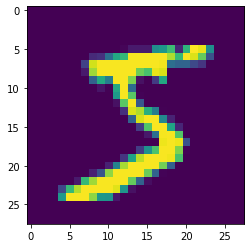

In [4]:
# reshaping and plotting the first input vector
img = np.reshape( train[ 0, 1 : ], newshape = ( 28, 28 ) )
plt.imshow( img )
plt.show()

In [5]:
# classification for first input vector
# the above plot is supposed to be a 5
train[ 0, 0 ]

5.0

In [6]:
max( train[ 0, 1 : ] )

255.0

In [7]:
# normalizing the input vectors
train[ :, 1 : ] = train[ :, 1 : ] / 255

In [8]:
# input matrix
X = train[ :, 1 : ]
X.shape

(60000, 784)

In [9]:
# target matrix
Y = np.ndarray( shape = ( len( train ), 10 ), dtype = np.float )
for i, n in np.ndenumerate( train[ :, 0 ] ) :
    vect = np.array( [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ], dtype = np.float )
    vect[ int( n ) ] = 1.0
    Y[ i ] = vect
Y.shape

(60000, 10)

In [10]:
# target and output vectors have 10 elements corresponding to the probability 
# that the corresponding input vector is each digit 0-9, after normalization
# thus, the network will have 10 output nodes
# the first target vector says that the first input vector has a probability of unity of being a 5
Y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

## Creating a new method to better display the model's predictions

In [11]:
class FeedForwardNeuralNetwork( FeedForwardNeuralNetwork ) :
    
    def output( self, input_array ) :
        '''
        Convert the Forward Propagation Output to a More Readable Format
        '''
        def index_of_largest_number_in( array ) :
            max_idx, max_num = 0, 0.0
            for i in range( len( array ) ) :
                if array[ i ] > max_num :
                    max_idx, max_num = i, array[ i ]
            return max_idx
        def output_with_confidence( array ) :
            idx = index_of_largest_number_in( array )
            return idx, round( 100 * array[ idx ] / array.sum(), 2 )
        
        if input_array.shape[ 0 ] == 1 or len( input_array.shape ) == 1 :
            img = np.reshape( input_array, newshape = ( 28, 28 ) )
            plt.imshow( img )
            plt.show()
            return output_with_confidence( 
                self.forwardpropagation( input_array ) 
                )
        return np.apply_along_axis( 
            func1d = output_with_confidence, 
            axis = 1, 
            arr = self.forwardpropagation( input_array ) 
            )

In [12]:
FFNN = FeedForwardNeuralNetwork( perceptrons_per_hidden_layer = [ 30 ] )
FFNN.train( X, Y, learning_rate = 0.1, batch_size = 10, max_epoch = 10 )

Maximum epoch encountered.


In [13]:
FFNN.score

5118.319927609555

In [14]:
# loading MNIST test data
test = np.loadtxt( 'mnist_test.csv', delimiter = ',', skiprows = 1 )
test.shape

(10000, 785)

In [15]:
# normalizing the data
test[ :, 1 : ] = test[ :, 1 : ] / 255

In [16]:
# input matrix
X = test[ :, 1 : ]
X.shape

(10000, 784)

In [17]:
# true values
Y = test[ :, 0 ]
Y.shape

(10000,)

## Let's run some tests

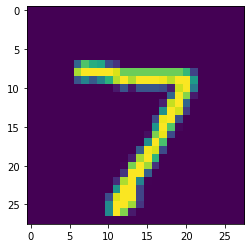

(7, 99.14)

In [18]:
# The model is 99.14% sure that the plot below is of the number 7
FFNN.output( X[0] )

In [19]:
Y[0] # The model is correct!

7.0

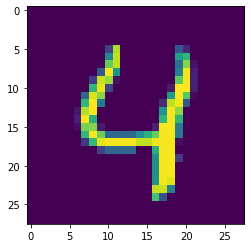

(4, 95.52)

In [20]:
# The model is 95.52% sure that the plot below is of the number 4
FFNN.output( X[4] )

In [21]:
Y[4] # The model is correct!

4.0

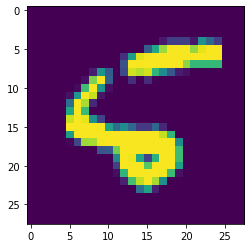

(6, 79.0)

In [22]:
# The model is 79% sure that the plot below is of the number 6
FFNN.output( X[8] )

In [23]:
Y[8] # The model is not correct, but I do not blame it

5.0

## Let's run a final test

In [24]:
# combining training and test data
X = np.concatenate( ( train[ :, 1 : ], test[ :, 1 : ] ) )
X.shape

(70000, 784)

In [25]:
total = np.concatenate( ( train[ :, 0 ], test[ :, 0 ] ) )
Y = np.ndarray( shape = ( len( total ), 10 ), dtype = np.float )
for i, n in np.ndenumerate( total ) :
    vect = np.array( [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ], dtype = np.float )
    vect[ int( n ) ] = 1.0
    Y[ i ] = vect
Y.shape

(70000, 10)

## K-Fold Cross Validation

In [26]:
class FeedForwardNeuralNetwork( FeedForwardNeuralNetwork  ) :
    
    def kfold_cross_validation( self, X, Y, k, 
                                learning_rate = 1.0, convergence = 0.01, 
                                batch_size = 10, max_epoch = 200, max_time = 60 ) :
        accuracy = 0.0
        split = len( X ) // int( k )
        shuffle = np.random.permutation( len( X ) )
        X, Y = X[ shuffle ], Y[ shuffle ]
        indices = np.arange( start = 0, stop = len( X ) )
        for i in range( int( k ) ) :
            train_left, test_indices, train_right = np.array_split( indices, [ i*split, ( i + 1 )*split ] )
            train_indices = np.concatenate( ( train_left, train_right ) )
            self.train( X[ train_indices ], Y[ train_indices ], 
                        learning_rate, convergence, batch_size, max_epoch, max_time )
            accuracy += ( self.output( X[ test_indices ] )[ :, 0 ] == np.where( Y[ test_indices ] == 1 )[ 1 ] ).mean()
        # average accuracy over k iterations
        print( '{} fold cross validation'.format( k ) )
        print( 'Accuracy: {}'.format( accuracy / k ) )
        return

In [27]:
# Training and testing model on all of the data
FFNN = FeedForwardNeuralNetwork( perceptrons_per_hidden_layer = [ 30 ] )
FFNN.kfold_cross_validation( X, Y, k = 5, learning_rate = 0.1, batch_size = 10, max_epoch = 10 )

Maximum epoch encountered.
Maximum epoch encountered.
Maximum epoch encountered.
Maximum epoch encountered.
Maximum epoch encountered.
5 fold cross validation
Accuracy: 0.9418714285714286
